# EE 467 Lab 2: Breaking CAPTCHAs with PyTorch

This notebook is the **PyTorch implementation** of the CAPTCHA breaking lab, converted from the original TensorFlow/Keras version.

## Overview
- Load and preprocess CAPTCHA images
- Extract individual characters from CAPTCHAs
- Build a CNN model using PyTorch
- Train the model to recognize characters
- Evaluate the full CAPTCHA recognition pipeline

**Note:** The results should be similar to the TensorFlow version, with minor differences due to different random initialization and implementation details.

## Install Dependencies

In [1]:
%pip install matplotlib scikit-learn "opencv-python>4" imutils torch torchvision

Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [2]:
import os
import pickle
import glob
import math
from pprint import pprint

import cv2
import numpy as np
import imutils
from imutils import paths
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Import helper functions
from lab_2_helpers import *

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Preprocessing

## Ground Truth Characters Extraction

Load CAPTCHA images and extract labels from filenames.

In [3]:
# Dataset images folder
CAPTCHA_IMAGE_FOLDER = "./captcha-images"

# List of all the captcha images we need to process
captcha_image_paths = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
# Review image paths
print(f"Total CAPTCHA images: {len(captcha_image_paths)}")
pprint(captcha_image_paths[:10])

Total CAPTCHA images: 1136
['./captcha-images/G5P5.png',
 './captcha-images/5VXL.png',
 './captcha-images/4NL5.png',
 './captcha-images/4GGZ.png',
 './captcha-images/G7J9.png',
 './captcha-images/E6M8.png',
 './captcha-images/7WPB.png',
 './captcha-images/5TN5.png',
 './captcha-images/L6US.png',
 './captcha-images/2A5R.png']


In [4]:
def extract_captcha_text(image_path):
    """ Extract correct CAPTCHA texts from file name of images. """
    # Extract file name of image from its path
    # e.g. "./captcha-images/2A2X.png" -> "2A2X.png"
    image_file_name = os.path.basename(image_path)
    # Extract base name of image, omitting file extension
    # e.g. "2A2X.png" -> "2A2X"
    return os.path.splitext(image_file_name)[0]

captcha_texts = [extract_captcha_text(image_path) for image_path in captcha_image_paths]
# Review extraction results
pprint(captcha_texts[:10])

['G5P5', '5VXL', '4NL5', '4GGZ', 'G7J9', 'E6M8', '7WPB', '5TN5', 'L6US', '2A5R']


## Loading and Transforming Images

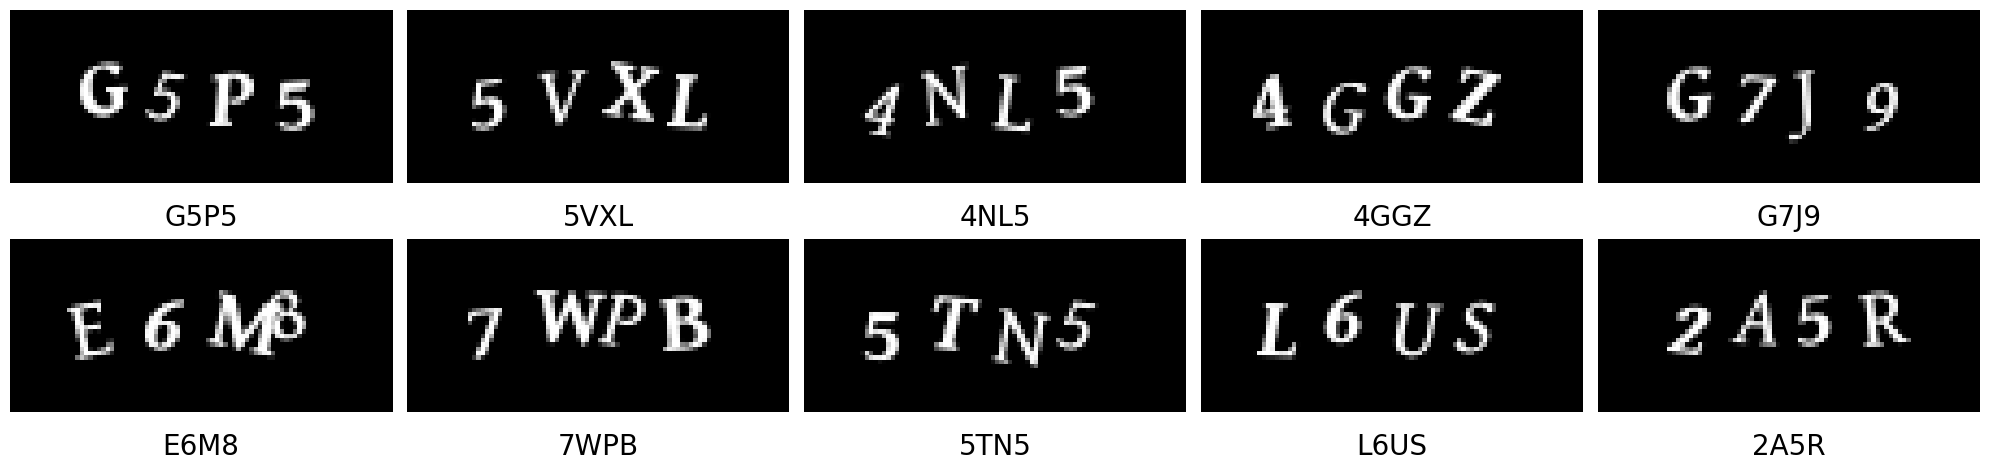

In [5]:
def load_transform_image(image_path):
    """ Load and transform image into grayscale with padding. """
    # 1) Load image with OpenCV
    image = cv2.imread(image_path)
    
    # 2) Convert image to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 3) Add extra padding (8px) around the image
    image_padded = cv2.copyMakeBorder(
        image_gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE
    )
    
    return image_padded

captcha_images = [load_transform_image(image_path) for image_path in captcha_image_paths]

# Review loaded CAPTCHAs
print_images(
    captcha_images[:10], n_rows=2, texts=captcha_texts[:10]
)

## Train-Test Split

In [6]:
# Train-validation-test split seed
TVT_SPLIT_SEED = 31528476

# Perform split on CAPTCHA images as well as labels
captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

print("Train-validation:", len(captcha_texts_tv))
print("Test:", len(captcha_texts_test))

Train-validation: 908
Test: 228


## Bounding Box Extraction

Extract individual characters from each CAPTCHA image using contour detection.

In [7]:
# Character images folder template
CHAR_IMAGE_FOLDER = f"./char-images-{TVT_SPLIT_SEED}"

def extract_chars(image):
    """ Find contours and extract characters inside each CAPTCHA. """
    # Threshold image and convert it to black-white
    image_bw = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    # Find contours (continuous blobs of pixels) the image
    contours = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    char_regions = []
    # Loop through each contour
    for contour in contours:
        # Get the rectangle that contains the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Compare the width and height of the bounding box,
        # detect if there are letters conjoined into one chunk
        if w / h > 1.25:
            # Bounding box is too wide for a single character
            # Split it in half into two letter regions
            half_width = int(w / 2)
            char_regions.append((x, y, half_width, h))
            char_regions.append((x + half_width, y, half_width, h))
        else:
            # Only a single letter in contour
            char_regions.append((x, y, w, h))

    # Ignore image if less or more than 4 regions detected
    if len(char_regions) != 4:
        return None
    # Sort regions by their X coordinates
    char_regions.sort(key=lambda x: x[0])

    # Character images
    char_images = []
    # Save each character as a single image
    for x, y, w, h in char_regions:
        # Extract character from image with 2px margin
        char_image = image[y - 2:y + h + 2, x - 2:x + w + 2]
        # Save character images
        char_images.append(char_image)

    # Return character images
    return char_images

def save_chars(char_images, captcha_text, save_dir, char_counts):
    """ Save character images to directory. """
    for char_image, char in zip(char_images, captcha_text):
        # Get the folder to save the image in
        save_path = os.path.join(save_dir, char)
        os.makedirs(save_path, exist_ok=True)

        # Write letter image to file
        char_count = char_counts.get(char, 1)
        char_image_path = os.path.join(save_path, f"{char_count}.png")
        cv2.imwrite(char_image_path, char_image)

        # Update count
        char_counts[char] = char_count + 1

# Force character extraction even if results are already available
FORCE_EXTRACT_CHAR = False

char_counts = {}
# Extract and save images for characters
if FORCE_EXTRACT_CHAR or not os.path.exists(CHAR_IMAGE_FOLDER):
    for captcha_image, captcha_text in zip(captcha_images_tv, captcha_texts_tv):
        # Extract character images
        char_images = extract_chars(captcha_image)
        # Skip if extraction failed
        if char_images is None:
            continue
        # Save character images
        save_chars(char_images, captcha_text, CHAR_IMAGE_FOLDER, char_counts)
    print(f"Extracted characters saved to {CHAR_IMAGE_FOLDER}")
else:
    print(f"Using existing character images from {CHAR_IMAGE_FOLDER}")

Using existing character images from ./char-images-31528476


## Label Encoding and Feature Preparation

In [8]:
# Path of occurred characters (labels)
LABELS_PATH = "./labels_pytorch.pkl"

def make_feature(image):
    """ Process character image and turn it into feature. """
    # Resize letter to 20*20
    image_resized = resize_to_fit(image, 20, 20)
    # Add extra dimension as the only channel
    feature = image_resized[..., None]
    return feature

def make_feature_label(image_path):
    """ Load character image and make feature-label pair from image path. """
    # Load image and make feature
    feature = make_feature(cv2.imread(image_path, cv2.COLOR_BGR2GRAY))
    # Extract label based on the directory the image is in
    label = image_path.split(os.path.sep)[-2]
    return feature, label

# Make features and labels from character image paths
features_tv, labels_tv = unzip((
    make_feature_label(image_path) for image_path in paths.list_images(CHAR_IMAGE_FOLDER)
))

# Scale raw pixel values into range [0, 1]
features_tv = np.array(features_tv, dtype="float") / 255

# For PyTorch, we use LabelEncoder for integer labels (CrossEntropyLoss expects class indices)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels_tv)

# Number of classes
n_classes = len(le.classes_)
print(f"Number of classes: {n_classes}")
print(f"Classes: {le.classes_}")

# Further split the training data into training and validation set
X_train, X_vali, y_train, y_vali = train_test_split(
    features_tv, labels_encoded, test_size=0.25, random_state=955996
)

# Save mapping from labels to encoding
with open(LABELS_PATH, "wb") as f:
    pickle.dump(le, f)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_vali)}")

Number of classes: 32
Classes: ['2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'J' 'K'
 'L' 'M' 'N' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
Training samples: 2676
Validation samples: 892


## Prepare PyTorch DataLoaders

In [9]:
# Convert to PyTorch tensors
# PyTorch expects (N, C, H, W) format, so we need to transpose from (N, H, W, C)
X_train_tensor = torch.FloatTensor(X_train).permute(0, 3, 1, 2)  # (N, 1, 20, 20)
X_vali_tensor = torch.FloatTensor(X_vali).permute(0, 3, 1, 2)
y_train_tensor = torch.LongTensor(y_train)
y_vali_tensor = torch.LongTensor(y_vali)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
vali_dataset = TensorDataset(X_vali_tensor, y_vali_tensor)

# Batch size
BATCH_SIZE = 32

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
vali_loader = DataLoader(vali_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(vali_loader)}")

Training batches: 84
Validation batches: 28


# Training

## Define the CNN Model in PyTorch

The architecture matches the TensorFlow version:

| Layer | Output Shape | Parameters |
|-------|--------------|------------|
| Input | (1, 20, 20) | - |
| Conv2D(20, 5x5, same) + ReLU | (20, 20, 20) | 520 |
| MaxPool2D(2x2) | (20, 10, 10) | - |
| Conv2D(50, 5x5, same) + ReLU | (50, 10, 10) | 25,050 |
| MaxPool2D(2x2) | (50, 5, 5) | - |
| Flatten | (1250,) | - |
| Dense(500) + ReLU | (500,) | 625,500 |
| Dense(n_classes) + Softmax | (n_classes,) | varies |

In [10]:
class CaptchaCNN(nn.Module):
    """
    CNN for CAPTCHA character classification.
    
    Architecture:
    - 2 Convolutional blocks (Conv2D + ReLU + MaxPool)
    - Flatten
    - 2 Fully connected layers
    """
    
    def __init__(self, n_classes):
        super(CaptchaCNN, self).__init__()
        
        # First convolution block
        # Input: (batch, 1, 20, 20) -> Output: (batch, 20, 10, 10)
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=20,
            kernel_size=5,
            stride=1,
            padding=2  # 'same' padding: (kernel_size - 1) / 2 = (5-1)/2 = 2
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolution block
        # Input: (batch, 20, 10, 10) -> Output: (batch, 50, 5, 5)
        self.conv2 = nn.Conv2d(
            in_channels=20,
            out_channels=50,
            kernel_size=5,
            stride=1,
            padding=2  # 'same' padding
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        # After pooling: 50 channels * 5 * 5 = 1250
        self.fc1 = nn.Linear(50 * 5 * 5, 500)
        self.fc2 = nn.Linear(500, n_classes)
        
        # Activation function
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # First conv block
        x = self.conv1(x)           # (batch, 20, 20, 20)
        x = self.relu(x)
        x = self.pool1(x)           # (batch, 20, 10, 10)
        
        # Second conv block
        x = self.conv2(x)           # (batch, 50, 10, 10)
        x = self.relu(x)
        x = self.pool2(x)           # (batch, 50, 5, 5)
        
        # Flatten
        x = x.view(x.size(0), -1)   # (batch, 1250)
        
        # Fully connected layers
        x = self.fc1(x)             # (batch, 500)
        x = self.relu(x)
        x = self.fc2(x)             # (batch, n_classes)
        
        # Note: No softmax here - CrossEntropyLoss includes it
        return x

# Create model
model = CaptchaCNN(n_classes).to(device)

# Print model summary
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

CaptchaCNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=32, bias=True)
  (relu): ReLU()
)

Total parameters: 667102
Trainable parameters: 667102


## Training Loop

In [11]:
# Hyperparameters
N_EPOCHS = 10
LEARNING_RATE = 0.001

# Loss function and optimizer
# CrossEntropyLoss combines LogSoftmax and NLLLoss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Path of model weights file
MODEL_WEIGHTS_PATH = "./captcha-model-pytorch.pth"
# Force training even if weights are already available
FORCE_TRAINING = True

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

if FORCE_TRAINING or not os.path.exists(MODEL_WEIGHTS_PATH):
    print("Starting training...")
    print("=" * 60)
    
    for epoch in range(N_EPOCHS):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        # Validate
        val_loss, val_acc = validate_epoch(model, vali_loader, criterion, device)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print progress
        print(f"Epoch {epoch+1}/{N_EPOCHS}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    
    print("=" * 60)
    print("Training complete!")
    
    # Save model weights
    torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
    print(f"Model saved to {MODEL_WEIGHTS_PATH}")
else:
    # Load model weights
    model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH))
    print(f"Model loaded from {MODEL_WEIGHTS_PATH}")

Starting training...
Epoch 1/10
  Train Loss: 1.8023 | Train Acc: 0.5120
  Val Loss:   0.3038 | Val Acc:   0.9339
Epoch 2/10
  Train Loss: 0.1517 | Train Acc: 0.9690
  Val Loss:   0.1033 | Val Acc:   0.9888
Epoch 3/10
  Train Loss: 0.0560 | Train Acc: 0.9884
  Val Loss:   0.0917 | Val Acc:   0.9843
Epoch 4/10
  Train Loss: 0.0324 | Train Acc: 0.9936
  Val Loss:   0.0863 | Val Acc:   0.9865
Epoch 5/10
  Train Loss: 0.0104 | Train Acc: 0.9981
  Val Loss:   0.0893 | Val Acc:   0.9877
Epoch 6/10
  Train Loss: 0.0068 | Train Acc: 0.9989
  Val Loss:   0.0908 | Val Acc:   0.9877
Epoch 7/10
  Train Loss: 0.0032 | Train Acc: 0.9996
  Val Loss:   0.0877 | Val Acc:   0.9888
Epoch 8/10
  Train Loss: 0.0023 | Train Acc: 0.9996
  Val Loss:   0.0856 | Val Acc:   0.9888
Epoch 9/10
  Train Loss: 0.0007 | Train Acc: 1.0000
  Val Loss:   0.0925 | Val Acc:   0.9888
Epoch 10/10
  Train Loss: 0.0004 | Train Acc: 1.0000
  Val Loss:   0.0957 | Val Acc:   0.9888
Training complete!
Model saved to ./captcha-mode

## Plot Training History

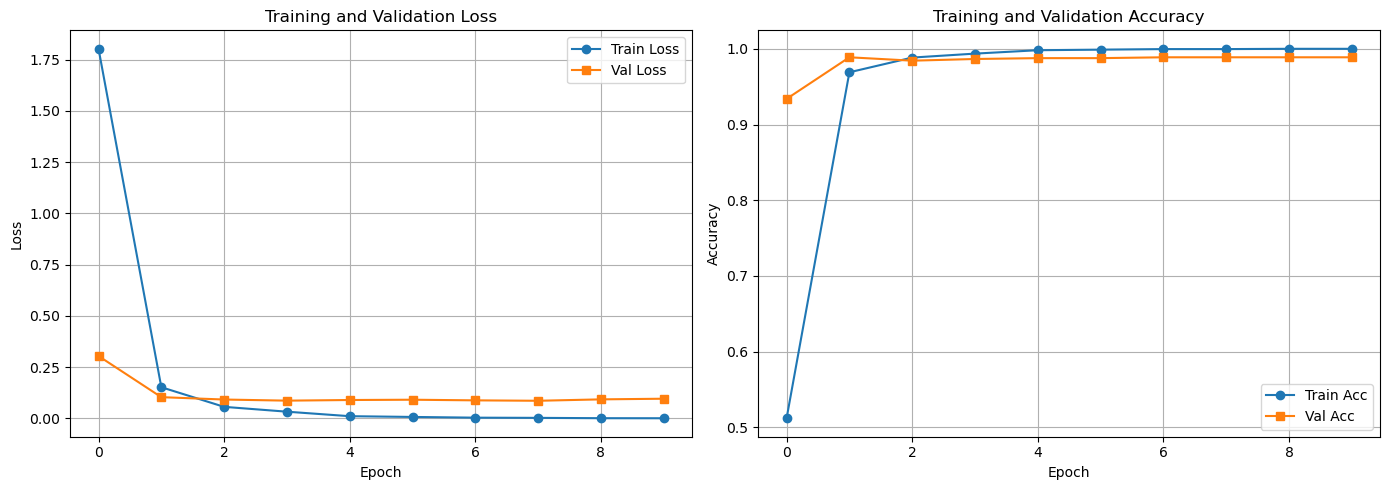

In [12]:
if history['train_loss']:  # Only plot if we trained
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss plot
    ax1.plot(history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(history['val_loss'], label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(history['train_acc'], label='Train Acc', marker='o')
    ax2.plot(history['val_acc'], label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Evaluation

Test the complete CAPTCHA recognition pipeline on the test set.

In [13]:
# Load labels from file
with open(LABELS_PATH, "rb") as f:
    le = pickle.load(f)

# Set model to evaluation mode
model.eval()

# Dummy character images for failed extractions
DUMMY_CHAR_IMAGES = np.zeros((4, 20, 20, 1))

# Indices of CAPTCHAs on which extractions failed
extract_failed_indices = []
# Extracted character images
char_images_test = []

# Extract character images and make features
for i, captcha_image in enumerate(captcha_images_test):
    # Extract character images
    char_images = extract_chars(captcha_image)
    
    if char_images:
        char_images_test.extend(char_images)
    else:
        # Use dummy character images as placeholder if extraction failed
        extract_failed_indices.append(i)
        char_images_test.extend(DUMMY_CHAR_IMAGES)

print(f"Failed extractions: {len(extract_failed_indices)}")

# Make features for character images
features_test = [make_feature(char_image) for char_image in char_images_test]
# Scale raw pixel values into range [0, 1]
features_test = np.array(features_test, dtype="float") / 255

# Convert to PyTorch tensor (N, C, H, W)
features_test_tensor = torch.FloatTensor(features_test).permute(0, 3, 1, 2).to(device)

# Predict labels with neural network
with torch.no_grad():
    outputs = model(features_test_tensor)
    _, predicted = torch.max(outputs, 1)
    preds_test = predicted.cpu().numpy()

# Convert encoded labels back to original
preds_test = le.inverse_transform(preds_test)

# Group all 4 characters for the same CAPTCHA
preds_test = ["".join(chars) for chars in group_every(preds_test, 4)]

# Update result for CAPTCHAs on which extractions failed
for i in extract_failed_indices:
    preds_test[i] = "-"

print(f"Total predictions: {len(preds_test)}")

Failed extractions: 3
Total predictions: 228


## Compute Accuracy and Visualize Results

In [14]:
# Number of CAPTCHAs to display
N_DISPLAY_SAMPLES = 10

# Number of test CAPTCHAs
n_test = len(captcha_texts_test)
# Number of correct predictions
n_correct = 0

# Indices of correct predictions
correct_indices = []
# Indices of incorrect predictions
incorrect_indices = []

for i, (pred_text, actual_text) in enumerate(zip(preds_test, captcha_texts_test)):
    if pred_text == actual_text:
        # 1) Update number of correct predictions
        n_correct += 1
        # 2) Collect index of correct prediction
        if len(correct_indices) < N_DISPLAY_SAMPLES:
            correct_indices.append(i)
    else:
        # 3) Collect index of incorrect prediction
        if len(incorrect_indices) < N_DISPLAY_SAMPLES:
            incorrect_indices.append(i)

# Show number of total / correct predictions and accuracy
print("=" * 50)
print("EVALUATION RESULTS (PyTorch)")
print("=" * 50)
print(f"# of test CAPTCHAs: {n_test}")
print(f"# correctly recognized: {n_correct}")
print(f"Accuracy: {n_correct/n_test:.4f} ({n_correct/n_test*100:.2f}%)")
print("=" * 50)

EVALUATION RESULTS (PyTorch)
# of test CAPTCHAs: 228
# correctly recognized: 216
Accuracy: 0.9474 (94.74%)



✅ CORRECT PREDICTIONS:


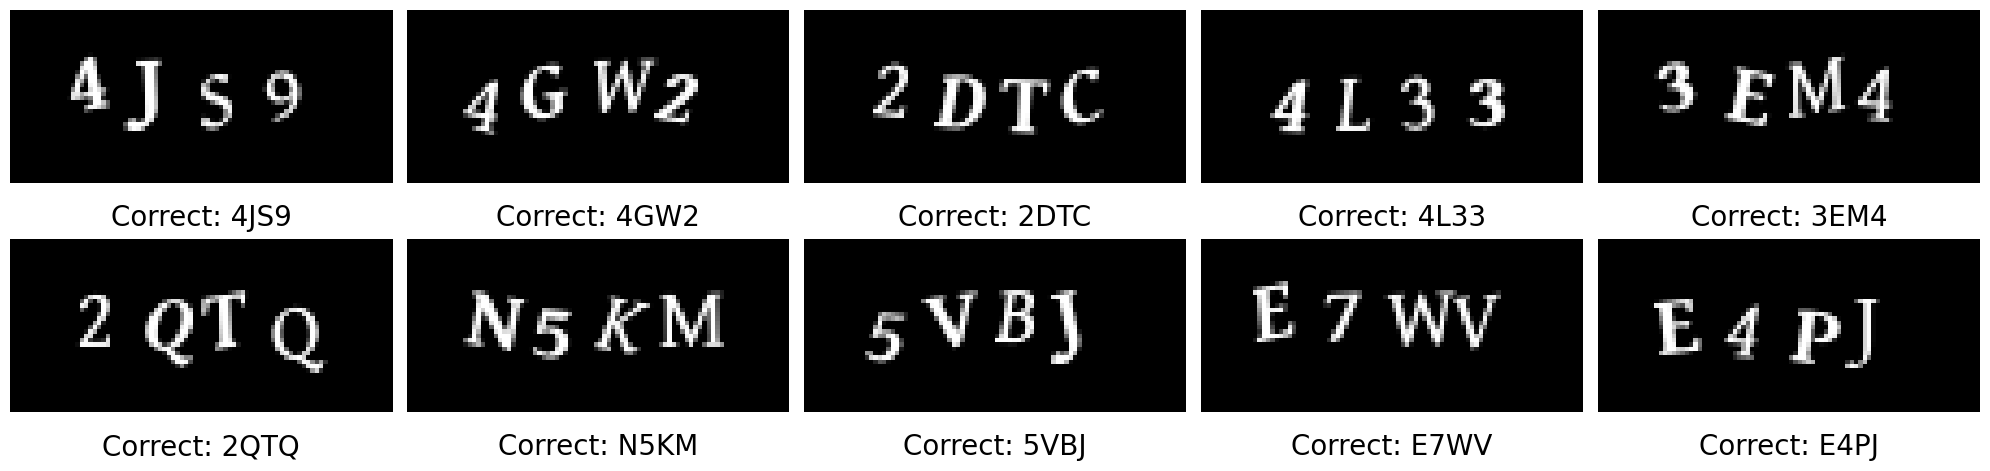

In [15]:
# Show correct predictions
print("\n✅ CORRECT PREDICTIONS:")
print_images(
    [captcha_images_test[i] for i in correct_indices],
    texts=[f"Correct: {captcha_texts_test[i]}" for i in correct_indices],
    n_rows=2
)


❌ INCORRECT PREDICTIONS:


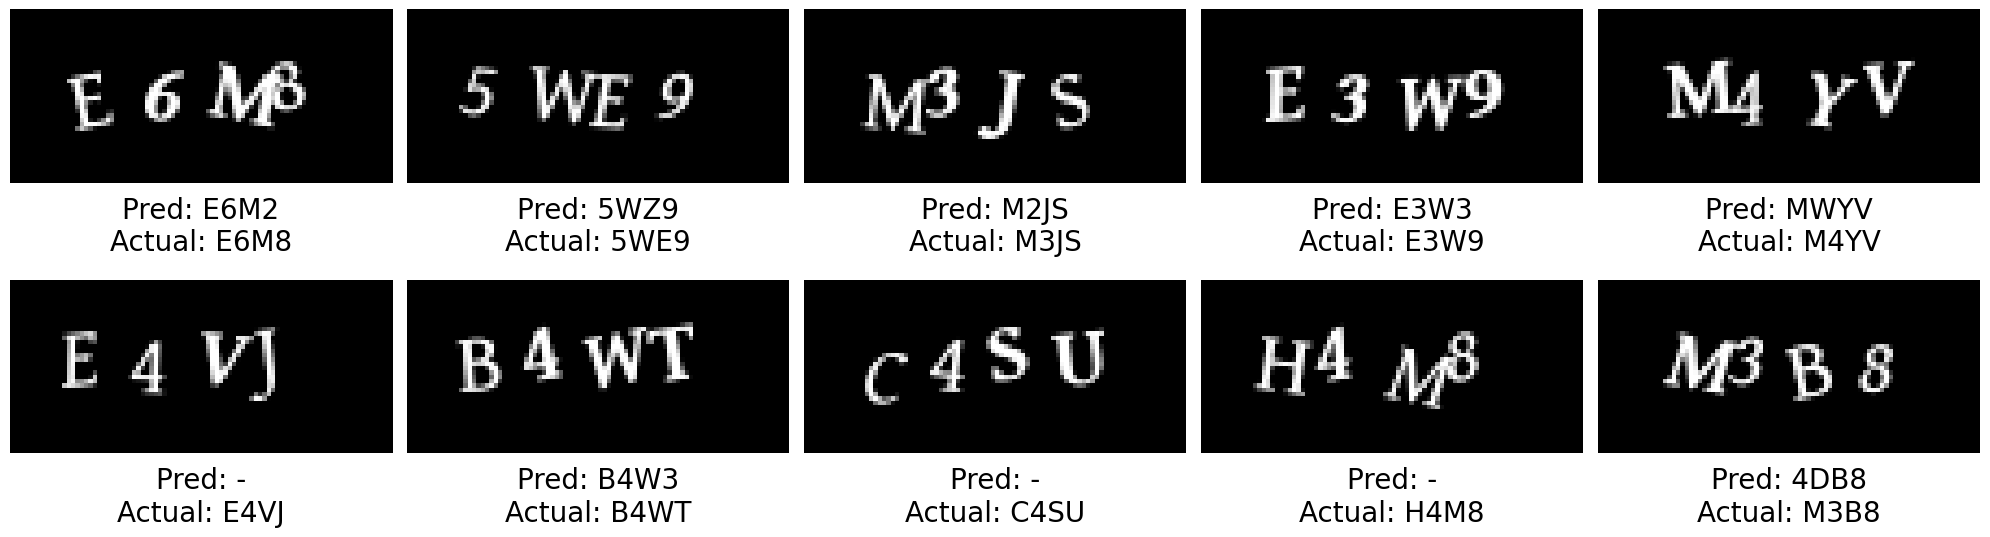

In [16]:
# Show incorrect predictions
print("\n❌ INCORRECT PREDICTIONS:")
print_images(
    [captcha_images_test[i] for i in incorrect_indices],
    texts=[
        f"Pred: {preds_test[i]}\nActual: {captcha_texts_test[i]}"
        for i in incorrect_indices
    ],
    n_rows=2,
    fig_size=(20, 6),
    text_center=(0.5, -0.25)
)

## Summary: TensorFlow vs PyTorch Comparison

| Aspect | TensorFlow/Keras | PyTorch |
|--------|-----------------|--------|
| Model Definition | `Sequential()` with `.add()` | `nn.Module` class with `__init__` and `forward` |
| Data Format | (N, H, W, C) | (N, C, H, W) |
| Training Loop | `model.fit()` | Manual loop with `optimizer.zero_grad()`, `loss.backward()`, `optimizer.step()` |
| Loss Function | Separate softmax + categorical_crossentropy | `CrossEntropyLoss` (includes softmax) |
| GPU Usage | Automatic | Manual with `.to(device)` |
| Model Saving | `.save_weights()` | `torch.save(model.state_dict())` |

Both frameworks should achieve similar accuracy on this CAPTCHA recognition task!

## References

1. How to break a CAPTCHA system in 15 minutes with Machine Learning: https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710
2. PyTorch Documentation: https://pytorch.org/docs/stable/index.html
3. PyTorch nn.Module: https://pytorch.org/docs/stable/nn.html
4. PyTorch Conv2d: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html